In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
circuits = pd.read_csv('data/circuits.csv')
constructor_results = pd.read_csv('data/constructor_results.csv')
constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
drivers = pd.read_csv('data/drivers.csv')
lap_times = pd.read_csv('data/lap_times.csv')
pit_stops = pd.read_csv('data/pit_stops.csv')
qualifying = pd.read_csv('data/qualifying.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')
seasons = pd.read_csv('data/seasons.csv')
sprint_results = pd.read_csv('data/sprint_results.csv')
status = pd.read_csv('data/status.csv')

tables = {
    'circuits': circuits,
    'constructor_results': constructor_results,
    'constructor_standings': constructor_standings,
    'constructors': constructors,
    'driver_standings': driver_standings,
    'drivers': drivers,
    'lap_times': lap_times,
    'pit_stops': pit_stops,
    'qualifying': qualifying,
    'races': races,
    'results': results,
    'seasons': seasons,
    'sprint_results': sprint_results,
    'status': status
}

# Random Insights

Driver numbers were introduced first in 2014  

In [15]:
display(drivers[drivers['number'] == '\\N'].sort_values(by='dob'))

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
741,741,etancelin,\N,\N,Philippe,Étancelin,1896-12-28,French,http://en.wikipedia.org/wiki/Philippe_%C3%89ta...
786,786,fagioli,\N,\N,Luigi,Fagioli,1898-06-09,Italian,http://en.wikipedia.org/wiki/Luigi_Fagioli
791,791,biondetti,\N,\N,Clemente,Biondetti,1898-08-18,Italian,http://en.wikipedia.org/wiki/Clemente_Biondetti
703,703,legat,\N,\N,Arthur,Legat,1898-11-01,Belgian,http://en.wikipedia.org/wiki/Arthur_Legat
589,589,chiron,\N,\N,Louis,Chiron,1899-08-03,Monegasque,http://en.wikipedia.org/wiki/Louis_Chiron
...,...,...,...,...,...,...,...,...,...
11,12,piquet_jr,\N,PIQ,Nelson,Piquet Jr.,1985-07-25,Brazilian,"http://en.wikipedia.org/wiki/Nelson_Piquet,_Jr."
815,816,ambrosio,\N,DAM,Jérôme,d'Ambrosio,1985-12-27,Belgian,http://en.wikipedia.org/wiki/J%C3%A9r%C3%B4me_...
66,67,buemi,\N,BUE,Sébastien,Buemi,1988-10-31,Swiss,http://en.wikipedia.org/wiki/S%C3%A9bastien_Buemi
818,819,pic,\N,PIC,Charles,Pic,1990-02-15,French,http://en.wikipedia.org/wiki/Charles_Pic


Some drivers have same code - their driverRef is the key

In [16]:
display(drivers[drivers['code'] == 'VER'])

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
817,818,vergne,25,VER,Jean-Éric,Vergne,1990-04-25,French,http://en.wikipedia.org/wiki/Jean-%C3%89ric_Ve...
829,830,max_verstappen,33,VER,Max,Verstappen,1997-09-30,Dutch,http://en.wikipedia.org/wiki/Max_Verstappen


Sometimes both father and son have been in F1

In [17]:
drivers[drivers['surname'] == 'Schumacher'] 

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
22,23,ralf_schumacher,\N,SCH,Ralf,Schumacher,1975-06-30,German,http://en.wikipedia.org/wiki/Ralf_Schumacher
29,30,michael_schumacher,\N,MSC,Michael,Schumacher,1969-01-03,German,http://en.wikipedia.org/wiki/Michael_Schumacher
852,854,mick_schumacher,47,MSC,Mick,Schumacher,1999-03-22,German,http://en.wikipedia.org/wiki/Mick_Schumacher


# Data Cleaning

Key relationships in the F1 dataset:

- races is our central table, containing information about each race event (1,125 races)
- drivers (859 entries) and constructors (212 teams) are our main entities
- results (26,519 entries) connects races, drivers, and constructors with race outcomes
- lap_times (575,029 entries) and pit_stops (10,990 entries) provide detailed information about each race and driver
- qualifying (10,254 entries) and sprint_results (300 entries) cover pre-race events

In [18]:
def analyze_dataset(df, name):
    print(f"\n{'='*50}")
    print(f"Analysis for {name} dataset")
    print(f"{'='*50}")
    
    print("\n Basic Information:")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    
    missing_values = df.isnull().sum()
    missing_percentages = (missing_values / len(df)) * 100
    if missing_values.sum() != 0:
        print("\n Missing Values Analysis:")
        for col, missing in missing_values.items():
            if missing > 0:
                print(f"{col}: {missing} missing values ({missing_percentages[col]:.2f}%)")
    
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"\n Duplicate Rows: {duplicates}")
        # Drop duplicates
        df = df.drop_duplicates()

datasets = {
    'circuits': circuits,
    'constructor_results': constructor_results,
    'constructor_standings': constructor_standings,
    'constructors': constructors,
    'driver_standings': driver_standings,
    'drivers': drivers,
    'lap_times': lap_times,
    'pit_stops': pit_stops,
    'qualifying': qualifying,
    'races': races,
    'seasons': seasons,
    'sprint_results': sprint_results,
    'status': status
}

# Run analysis on each dataset
for name, df in datasets.items():
    analyze_dataset(df, name)


Analysis for circuits dataset

 Basic Information:
Number of rows: 77
Number of columns: 9

Analysis for constructor_results dataset

 Basic Information:
Number of rows: 12505
Number of columns: 5

Analysis for constructor_standings dataset

 Basic Information:
Number of rows: 13271
Number of columns: 7

Analysis for constructors dataset

 Basic Information:
Number of rows: 212
Number of columns: 5

Analysis for driver_standings dataset

 Basic Information:
Number of rows: 34595
Number of columns: 7

Analysis for drivers dataset

 Basic Information:
Number of rows: 859
Number of columns: 9

Analysis for lap_times dataset

 Basic Information:
Number of rows: 575029
Number of columns: 6

Analysis for pit_stops dataset

 Basic Information:
Number of rows: 10990
Number of columns: 7

Analysis for qualifying dataset

 Basic Information:
Number of rows: 10254
Number of columns: 9

 Missing Values Analysis:
q2: 13 missing values (0.13%)
q3: 27 missing values (0.26%)

Analysis for races datas

# Data Transformation

## Races dataset

In [19]:
races.tail()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1120,1140,2024,20,32,Mexico City Grand Prix,2024-10-27,20:00:00,https://en.wikipedia.org/wiki/2024_Mexico_City...,2024-10-25,18:30:00,2024-10-25,22:00:00,2024-10-26,17:30:00,2024-10-26,21:00:00,\N,\N
1121,1141,2024,21,18,São Paulo Grand Prix,2024-11-03,17:00:00,https://en.wikipedia.org/wiki/2024_S%C3%A3o_Pa...,2024-11-01,14:30:00,2024-11-01,18:30:00,\N,\N,2024-11-02,18:00:00,2024-11-02,14:00:00
1122,1142,2024,22,80,Las Vegas Grand Prix,2024-11-23,06:00:00,https://en.wikipedia.org/wiki/2024_Las_Vegas_G...,2024-11-21,02:30:00,2024-11-21,06:00:00,2024-11-22,02:30:00,2024-11-22,06:00:00,\N,\N
1123,1143,2024,23,78,Qatar Grand Prix,2024-12-01,17:00:00,https://en.wikipedia.org/wiki/2024_Qatar_Grand...,2024-11-29,13:30:00,2024-11-29,17:30:00,\N,\N,2024-11-30,17:00:00,2024-11-30,13:00:00
1124,1144,2024,24,24,Abu Dhabi Grand Prix,2024-12-08,13:00:00,https://en.wikipedia.org/wiki/2024_Abu_Dhabi_G...,2024-12-06,09:30:00,2024-12-06,13:00:00,2024-12-07,10:30:00,2024-12-07,14:00:00,\N,\N


In [20]:
for name, df in tables.items():
    print(f"\n{name} dataset:")
    display(df.tail())


circuits dataset:


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
72,75,portimao,Autódromo Internacional do Algarve,Portimão,Portugal,37.2270,-8.6267,108,http://en.wikipedia.org/wiki/Algarve_Internati...
73,76,mugello,Autodromo Internazionale del Mugello,Mugello,Italy,43.9975,11.3719,255,http://en.wikipedia.org/wiki/Mugello_Circuit
74,77,jeddah,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.6319,39.1044,15,http://en.wikipedia.org/wiki/Jeddah_Street_Cir...
75,78,losail,Losail International Circuit,Al Daayen,Qatar,25.4900,51.4542,12,http://en.wikipedia.org/wiki/Losail_Internatio...
76,79,miami,Miami International Autodrome,Miami,USA,25.9581,-80.2389,0,http://en.wikipedia.org/wiki/Miami_Internation...



constructor_results dataset:


,constructorResultsId,raceId,constructorId,points,status
12500,17005,1132,117,10.0,\N
12501,17006,1132,3,2.0,\N
12502,17007,1132,215,1.0,\N
12503,17008,1132,15,0.0,\N
12504,17009,1132,214,0.0,\N



constructor_standings dataset:


,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
13266,28848,1132,15,0.0,10,10,0
13267,28849,1132,210,27.0,7,7,0
13268,28850,1132,215,31.0,6,6,0
13269,28851,1132,3,4.0,9,9,0
13270,28852,1132,214,9.0,8,8,0



constructors dataset:


,constructorId,constructorRef,name,nationality,url
207,210,haas,Haas F1 Team,American,http://en.wikipedia.org/wiki/Haas_F1_Team
208,211,racing_point,Racing Point,British,http://en.wikipedia.org/wiki/Racing_Point_F1_Team
209,213,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri
210,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team
211,215,rb,RB F1 Team,Italian,http://en.wikipedia.org/wiki/RB_Formula_One_Team



driver_standings dataset:


,driverStandingsId,raceId,driverId,points,position,positionText,wins
34590,72867,1132,839,3.0,18,18,0
34591,72868,1132,842,6.0,15,15,0
34592,72869,1132,822,0.0,21,21,0
34593,72870,1132,858,0.0,20,20,0
34594,72871,1132,860,6.0,14,14,0



drivers dataset:


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
854,856,de_vries,21,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries
855,857,piastri,81,PIA,Oscar,Piastri,2001-04-06,Australian,http://en.wikipedia.org/wiki/Oscar_Piastri
856,858,sargeant,2,SAR,Logan,Sargeant,2000-12-31,American,http://en.wikipedia.org/wiki/Logan_Sargeant
857,859,lawson,40,LAW,Liam,Lawson,2002-02-11,New Zealander,http://en.wikipedia.org/wiki/Liam_Lawson
858,860,bearman,38,BEA,Oliver,Bearman,2005-05-08,British,http://en.wikipedia.org/wiki/Oliver_Bearman



lap_times dataset:


,raceId,driverId,lap,position,time,milliseconds
575024,1131,858,65,19,1:10.742,70742
575025,1131,858,66,19,1:10.855,70855
575026,1131,858,67,19,1:12.454,72454
575027,1131,858,68,19,1:13.607,73607
575028,1131,858,69,19,1:11.489,71489



pit_stops dataset:


,raceId,driverId,stop,lap,time,duration,milliseconds
10985,1132,807,2,39,16:06:28,30.265,30265
10986,1132,840,2,39,16:06:33,29.469,29469
10987,1132,839,4,38,16:06:52,29.086,29086
10988,1132,815,4,47,16:20:38,28.871,28871
10989,1132,832,3,50,16:22:59,28.706,28706



qualifying dataset:


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
10249,10307,1132,822,15,77,16,1:32.431,\N,\N
10250,10308,1132,825,210,20,17,1:32.905,\N,\N
10251,10309,1132,839,214,31,18,1:34.557,\N,\N
10252,10310,1132,815,9,11,19,1:38.348,\N,\N
10253,10311,1132,842,214,10,20,1:39.804,\N,\N



races dataset:


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1120,1140,2024,20,32,Mexico City Grand Prix,2024-10-27,20:00:00,https://en.wikipedia.org/wiki/2024_Mexico_City...,2024-10-25,18:30:00,2024-10-25,22:00:00,2024-10-26,17:30:00,2024-10-26,21:00:00,\N,\N
1121,1141,2024,21,18,São Paulo Grand Prix,2024-11-03,17:00:00,https://en.wikipedia.org/wiki/2024_S%C3%A3o_Pa...,2024-11-01,14:30:00,2024-11-01,18:30:00,\N,\N,2024-11-02,18:00:00,2024-11-02,14:00:00
1122,1142,2024,22,80,Las Vegas Grand Prix,2024-11-23,06:00:00,https://en.wikipedia.org/wiki/2024_Las_Vegas_G...,2024-11-21,02:30:00,2024-11-21,06:00:00,2024-11-22,02:30:00,2024-11-22,06:00:00,\N,\N
1123,1143,2024,23,78,Qatar Grand Prix,2024-12-01,17:00:00,https://en.wikipedia.org/wiki/2024_Qatar_Grand...,2024-11-29,13:30:00,2024-11-29,17:30:00,\N,\N,2024-11-30,17:00:00,2024-11-30,13:00:00
1124,1144,2024,24,24,Abu Dhabi Grand Prix,2024-12-08,13:00:00,https://en.wikipedia.org/wiki/2024_Abu_Dhabi_G...,2024-12-06,09:30:00,2024-12-06,13:00:00,2024-12-07,10:30:00,2024-12-07,14:00:00,\N,\N



results dataset:


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
26514,26520,1132,839,214,31,18,16,16,16,0.0,50,\N,\N,46,16,1:30.875,233.371,12
26515,26521,1132,815,9,11,0,17,17,17,0.0,50,\N,\N,50,6,1:29.707,236.409,12
26516,26522,1132,855,15,24,14,18,18,18,0.0,50,\N,\N,43,17,1:31.014,233.014,12
26517,26523,1132,847,131,63,1,\N,R,19,0.0,33,\N,\N,3,19,1:31.298,232.289,34
26518,26524,1132,842,214,10,19,\N,W,20,0.0,0,\N,\N,\N,0,\N,\N,6



seasons dataset:


,year,url
70,2020,http://en.wikipedia.org/wiki/2020_Formula_One_...
71,2021,http://en.wikipedia.org/wiki/2021_Formula_One_...
72,2022,http://en.wikipedia.org/wiki/2022_Formula_One_...
73,2023,http://en.wikipedia.org/wiki/2023_Formula_One_...
74,2024,https://en.wikipedia.org/wiki/2024_Formula_One...



sprint_results dataset:


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
295,296,1131,858,3,2,15,16,16,16,0,23,+44.076,1645465,6,1:10.488,1
296,297,1131,848,3,23,0,17,17,17,0,23,+44.673,1646062,8,1:10.562,1
297,298,1131,822,15,77,18,18,18,18,0,23,+46.511,1647900,8,1:10.590,1
298,299,1131,807,210,27,17,19,19,19,0,23,+48.423,1649812,4,1:10.512,1
299,300,1131,855,15,24,19,20,20,20,0,23,+53.143,1654532,6,1:10.613,1



status dataset:


,statusId,status
134,137,Damage
135,138,Debris
136,139,Illness
137,140,Undertray
138,141,Cooling system


In [21]:
def aggregate_performance_metrics():
    """
    Creates summary statistics and performance metrics.
    """
    
    driver_season_stats = results.merge(races[['raceId', 'year']], on='raceId')
    invalid_position = driver_season_stats[driver_season_stats['position'] == '\\N']
    print("\nDNFs with reasons:")
    display(invalid_position.merge(status, on='statusId')[['raceId', 'year', 'driverId', 'position', 'status']])
    
    # count DNFs
    dnf_count = invalid_position.groupby(['year', 'driverId']).agg({'position': 'count'}).reset_index().rename(columns={'position': 'dnf_count'})
    
    # Filter valid entries and convert datatypes
    driver_season_stats = driver_season_stats[
        (driver_season_stats['position'] != '\\N') & 
        (driver_season_stats['milliseconds'] != '\\N')
    ]
    driver_season_stats['position'] = driver_season_stats['position'].astype(int)
    driver_season_stats['points'] = driver_season_stats['points'].astype(float)
    driver_season_stats['milliseconds'] = driver_season_stats['milliseconds'].astype(float)
    
    # Driver performance by season
    driver_season_summary = driver_season_stats.groupby(['year', 'driverId']).agg({
        'points': 'sum',
        'position': ['mean', 'min'],
        'milliseconds': ['mean', 'std']
    }).reset_index()
    
    driver_season_summary.columns = ['year', 'driverId', 'total_points', 
                                   'avg_position', 'best_position',
                                   'avg_race_time', 'race_time_std']
    
    # Now merge with DNF counts
    driver_season_summary = driver_season_summary.merge(dnf_count, on=['year', 'driverId'], how='left').fillna(0)
    driver_season_summary = driver_season_summary.merge(drivers[['driverId', 'forename', 'surname']], on='driverId').drop('driverId', axis=1)
    
    # Constructor performance trends
    constructor_trends = results.merge(races[['raceId', 'year']], on='raceId')
    constructor_summary = constructor_trends.groupby(['year', 'constructorId']).agg({
        'points': 'sum',
        'laps': 'sum'
    }).reset_index()
    constructor_summary = constructor_summary.merge(constructors[['constructorId', 'name']], on='constructorId').drop('constructorId', axis=1)
    
    return {
        'driver_season_stats': driver_season_summary,
        'constructor_trends': constructor_summary
    }

for k, a in aggregate_performance_metrics().items():
    print(f"\n{k}:")
    display(a)


DNFs with reasons:


,raceId,year,driverId,position,status
0,18,2008,9,\N,Collision
1,18,2008,14,\N,Collision
2,18,2008,17,\N,Collision
3,18,2008,18,\N,Collision
4,18,2008,19,\N,Collision
...,...,...,...,...,...
10923,1075,2022,822,\N,Cooling system
10924,1084,2022,849,\N,Undertray
10925,1085,2022,852,\N,Undertray
10926,1111,2023,844,\N,Undertray



driver_season_stats:


,year,total_points,avg_position,best_position,avg_race_time,race_time_std,dnf_count,forename,surname
0,1950,26.0,1.000000,1,1.077250e+07,7.811366e+05,4.0,Juan,Fangio
1,1951,36.0,1.400000,1,1.036435e+07,1.886459e+06,1.0,Juan,Fangio
2,1953,28.0,1.750000,1,1.032862e+07,4.857895e+05,5.0,Juan,Fangio
3,1954,50.0,1.000000,1,1.082572e+07,1.413007e+06,0.0,Juan,Fangio
4,1955,40.0,1.200000,1,1.016344e+07,1.023500e+06,1.0,Juan,Fangio
...,...,...,...,...,...,...,...,...,...
1400,2024,112.0,5.750000,2,5.773049e+06,1.098335e+06,0.0,Oscar,Piastri
1401,2023,1.0,14.333333,10,5.369224e+06,5.702680e+05,5.0,Logan,Sargeant
1402,2024,0.0,14.000000,11,5.591842e+06,7.860517e+05,2.0,Logan,Sargeant
1403,2023,2.0,11.000000,9,6.541892e+06,2.090496e+06,0.0,Liam,Lawson



constructor_trends:


,year,points,laps,name
0,1950,21.00,689,Ferrari
1,1951,86.00,1511,Ferrari
2,1952,120.50,2257,Ferrari
3,1953,122.50,2561,Ferrari
4,1954,80.28,1886,Ferrari
...,...,...,...,...
1106,2021,155.00,2409,Alpine F1 Team
1107,2022,170.00,2361,Alpine F1 Team
1108,2023,110.00,2360,Alpine F1 Team
1109,2024,9.00,1271,Alpine F1 Team



Race Duration Changes:
Average race time in 1950.0: 2.66 hours
Average race time in 2024.0: 1.58 hours
Change: -1.08 hours (-40.5% change)

Fastest average races: 1991.0 (1.41 hours)
Slowest average races: 1954.0 (3.53 hours)


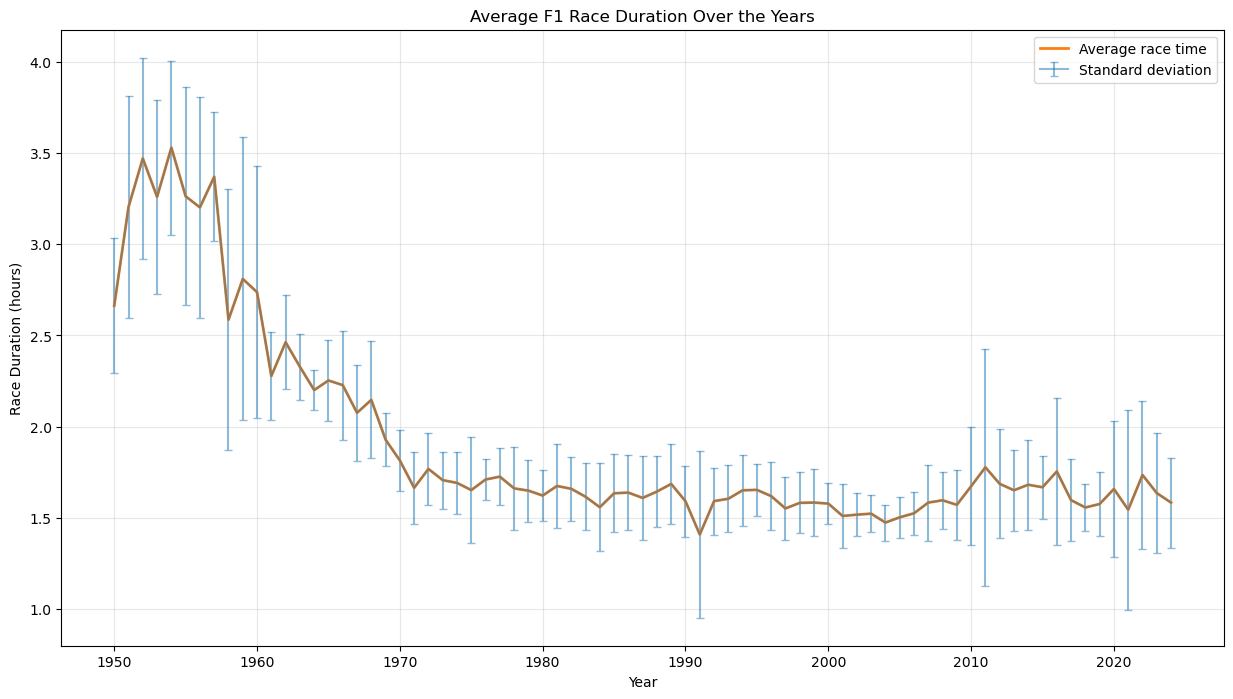

In [22]:
race_results = results.merge(races[['raceId', 'year']], on='raceId')
race_results = race_results.merge(constructors[['constructorId', 'name']], on='constructorId')

# Calculate average race time per year across all constructors
race_times = race_results[race_results['milliseconds'] != '\\N'].copy()
race_times['hours'] = race_times['milliseconds'].astype(float) / (1000 * 60 * 60)  

yearly_times = race_times.groupby('year')['hours'].agg(['mean', 'std', 'count']).reset_index()
yearly_times = yearly_times[yearly_times['count'] > 5]  # Filter years with enough data

plt.figure(figsize=(15, 8))
plt.errorbar(yearly_times['year'], 
            yearly_times['mean'], 
            yerr=yearly_times['std'],
            alpha=0.5,
            capsize=3,
            label='Standard deviation')

plt.plot(yearly_times['year'], yearly_times['mean'], linewidth=2, label='Average race time')

plt.title('Average F1 Race Duration Over the Years')
plt.xlabel('Year')
plt.ylabel('Race Duration (hours)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add trend comparison annotations
earliest_time = yearly_times.iloc[0]['mean']
latest_time = yearly_times.iloc[-1]['mean']
time_diff = latest_time - earliest_time

print(f"\nRace Duration Changes:")
print(f"Average race time in {yearly_times.iloc[0]['year']}: {earliest_time:.2f} hours")
print(f"Average race time in {yearly_times.iloc[-1]['year']}: {latest_time:.2f} hours")
print(f"Change: {time_diff:.2f} hours ({(time_diff/earliest_time * 100):.1f}% change)")

# Show fastest and slowest years
fastest_year = yearly_times.loc[yearly_times['mean'].idxmin()]
slowest_year = yearly_times.loc[yearly_times['mean'].idxmax()]
print(f"\nFastest average races: {fastest_year['year']} ({fastest_year['mean']:.2f} hours)")
print(f"Slowest average races: {slowest_year['year']} ({slowest_year['mean']:.2f} hours)")

plt.show()

## Analysis of Race Duration and Calendar Evolution:
F1 races have become significantly shorter and more standardized since the 1950s, with average race duration dropping from 2.66 hours to 1.58 hours (40.5% reduction). The most extreme year was 1954 with 3.53-hour races, while 1991 saw the shortest average at 1.41 hours. This trend toward shorter races aligns with modern F1's focus on sprint formats and tighter racing. Meanwhile, the calendar has expanded dramatically, from just 7-8 races in the early years to over 20 races today, showing F1's growth into a truly global championship with a much more demanding schedule

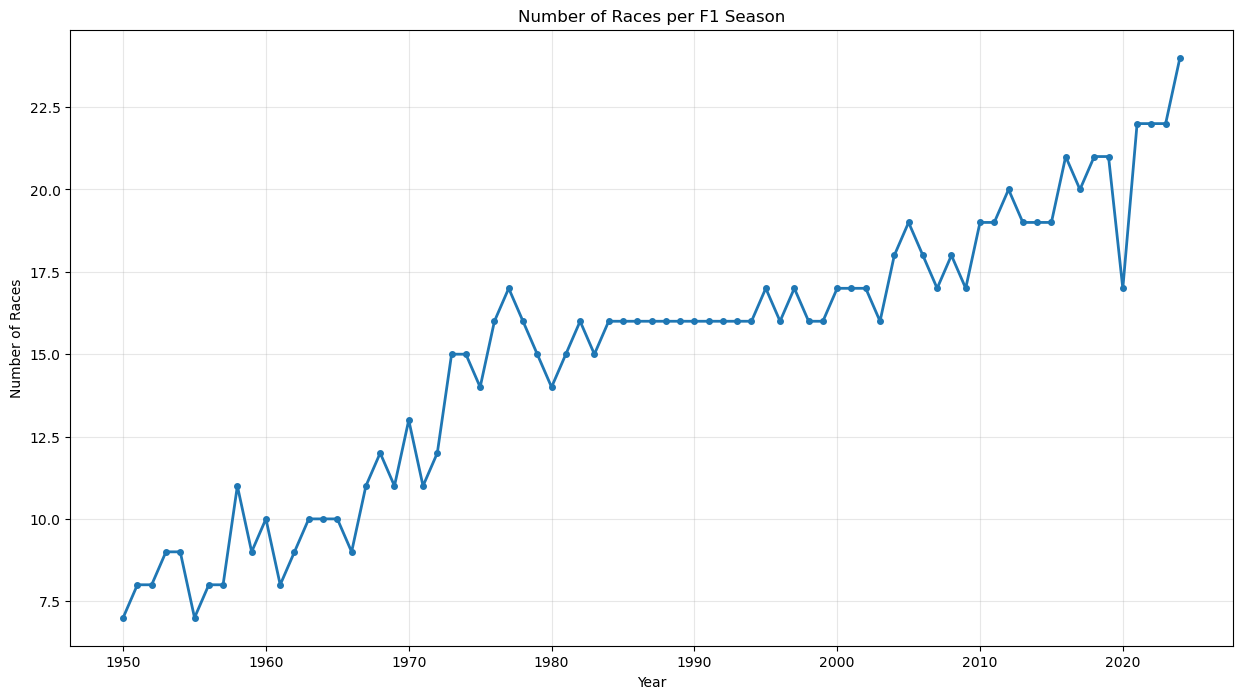

First season (1950): 7 races
Latest season (2024): 24 races
Most races: 24 (Year: 2024)
Fewest races: 7 (Year: 1950)


In [23]:
# Count races per season
races_per_year = races.groupby('year').size().reset_index(name='race_count').astype(int)

plt.figure(figsize=(15, 8))
plt.plot(races_per_year['year'], races_per_year['race_count'], 
        marker='o', linewidth=2, markersize=4)
plt.grid(True, alpha=0.3)
plt.title('Number of Races per F1 Season')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.show()

print(f"First season (1950): {races_per_year.iloc[0]['race_count']} races")
print(f"Latest season (2024): {races_per_year.iloc[-1]['race_count']} races")
print(f"Most races: {races_per_year['race_count'].max()} (Year: {races_per_year.loc[races_per_year['race_count'].idxmax(), 'year']})")
print(f"Fewest races: {races_per_year['race_count'].min()} (Year: {races_per_year.loc[races_per_year['race_count'].idxmin(), 'year']})")

The races may have been shorthened but luckily their count has been increasing over the years.

In [24]:
def get_driver_stats_comparison(drivers_df, results_df, qualifying_df, races_df):
    schumacher_id = drivers_df[
        (drivers_df['forename'] == 'Michael') & 
        (drivers_df['surname'] == 'Schumacher')
    ]['driverId'].iloc[0]
    
    hamilton_id = drivers_df[
        (drivers_df['forename'] == 'Lewis') & 
        (drivers_df['surname'] == 'Hamilton')
    ]['driverId'].iloc[0]
    
    def get_driver_stats(driver_id):
        wins = results_df[
            (results_df['driverId'] == driver_id) & 
            (results_df['position'] == '1')
        ].shape[0]
        
        races = results_df[results_df['driverId'] == driver_id].shape[0]
        
        qualifying_sessions = qualifying_df[qualifying_df['driverId'] == driver_id].shape[0]
        
        poles = qualifying_df[
            (qualifying_df['driverId'] == driver_id) & 
            (qualifying_df['position'] == 1)
        ].shape[0]
        
        points = results_df[results_df['driverId'] == driver_id]['points'].sum()
        
        podiums = results_df[
            (results_df['driverId'] == driver_id) & 
            (results_df['position'].isin(['1', '2', '3']))
        ].shape[0]
        
        dnfs = results_df[
            (results_df['driverId'] == driver_id) & 
            (results_df['positionText'] == 'R')
        ].shape[0]
        
        return {
            'wins': wins,
            'races': races,
            'qualifying': qualifying_sessions,
            'poles': poles,
            'podiums': podiums,
            'dnf': dnfs,
        }
    
    schumacher_stats = get_driver_stats(schumacher_id)
    hamilton_stats = get_driver_stats(hamilton_id)
    
    # Print comparison
    print("Statistical Comparison: Schumacher vs Hamilton")
    print("=" * 50)
    for metric in schumacher_stats.keys():
        print(f"{metric.upper():<20} {schumacher_stats[metric]:<15} {hamilton_stats[metric]}")
    
    return schumacher_stats, hamilton_stats

schumacher_stats, hamilton_stats = get_driver_stats_comparison(
    drivers, results, qualifying, races
)

Statistical Comparison: Schumacher vs Hamilton
WINS                 91              104
RACES                308             344
QUALIFYING           192             344
POLES                36              107
PODIUMS              155             199
DNF                  64              27


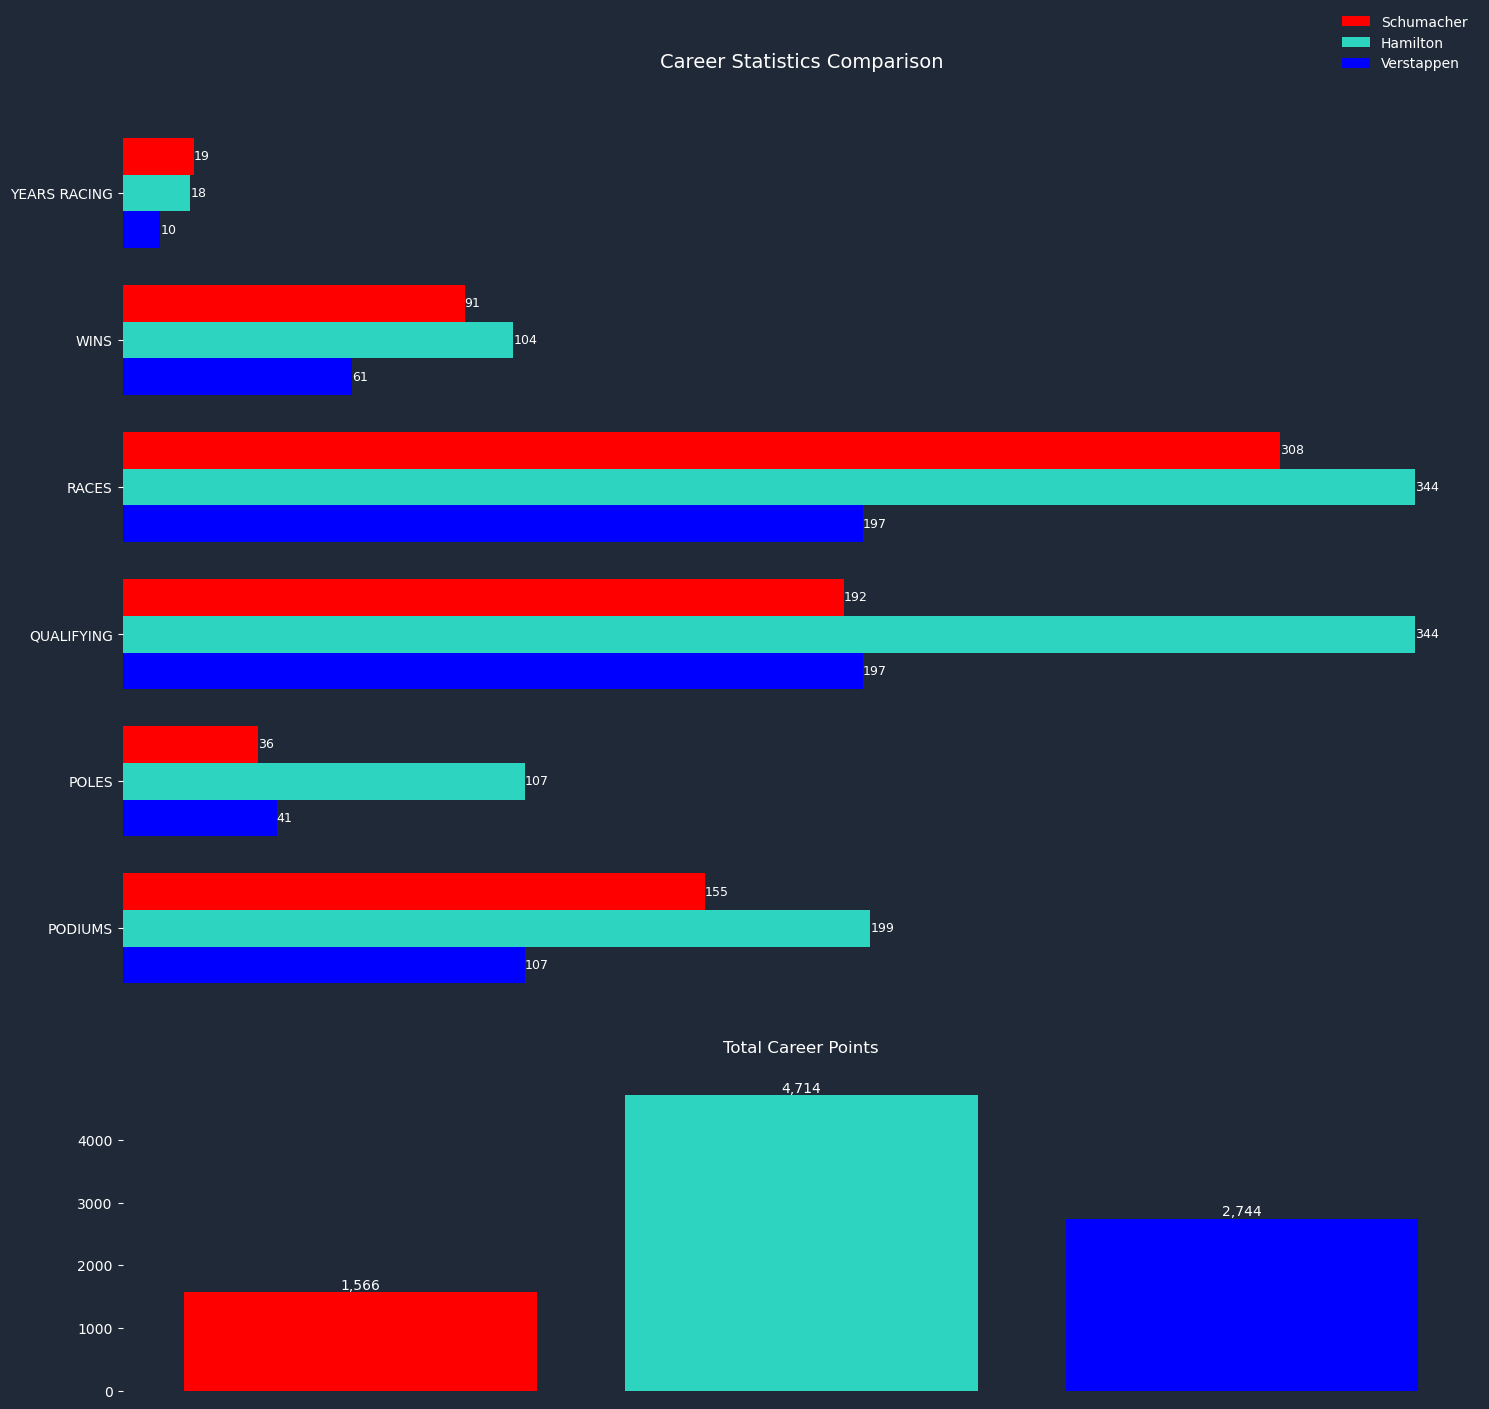

In [25]:
def create_f1_comparison_plots(drivers_df, results_df, qualifying_df, races_df):
    schumacher_id = drivers_df[
        (drivers_df['forename'] == 'Michael') & 
        (drivers_df['surname'] == 'Schumacher')
    ]['driverId'].iloc[0]
    
    hamilton_id = drivers_df[
        (drivers_df['forename'] == 'Lewis') & 
        (drivers_df['surname'] == 'Hamilton')
    ]['driverId'].iloc[0]
    
    verstappen_id = drivers_df[
        (drivers_df['forename'] == 'Max') & 
        (drivers_df['surname'] == 'Verstappen')
    ]['driverId'].iloc[0]
    
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14), height_ratios=[3, 1])
    
    # First plot (Career Statistics)
    def get_driver_stats(driver_id):
        driver_years = results_df[results_df['driverId'] == driver_id].merge(
            races_df[['raceId', 'year']], on='raceId'
        )['year'].nunique()
        
        wins = results_df[
            (results_df['driverId'] == driver_id) & 
            (results_df['position'] == '1')
        ].shape[0]
        
        races = results_df[results_df['driverId'] == driver_id].shape[0]
        qualifying_sessions = qualifying_df[qualifying_df['driverId'] == driver_id].shape[0]
        
        poles = qualifying_df[
            (qualifying_df['driverId'] == driver_id) & 
            (qualifying_df['position'] == 1)
        ].shape[0]
        
        podiums = results_df[
            (results_df['driverId'] == driver_id) & 
            (results_df['position'].isin(['1', '2', '3']))
        ].shape[0]
        
        return {
            'YEARS RACING': driver_years,
            'WINS': wins,
            'RACES': races,
            'QUALIFYING': qualifying_sessions,
            'POLES': poles,
            'PODIUMS': podiums,
        }
    
    # Get career stats
    schumacher_stats = get_driver_stats(schumacher_id)
    hamilton_stats = get_driver_stats(hamilton_id)
    verstappen_stats = get_driver_stats(verstappen_id)
    
    metrics = list(schumacher_stats.keys())
    schumacher_values = list(schumacher_stats.values())
    hamilton_values = list(hamilton_stats.values())
    verstappen_values = list(verstappen_stats.values())
    
    # Plot career stats
    y_pos = np.arange(len(metrics))
    bar_height = 0.25
    
    ax1.barh(y_pos - bar_height, schumacher_values, bar_height, 
             label='Schumacher', color='#ff0000')
    ax1.barh(y_pos, hamilton_values, bar_height, 
             label='Hamilton', color='#2dd4bf')
    ax1.barh(y_pos + bar_height, verstappen_values, bar_height, 
             label='Verstappen', color='blue')
    
    def add_value_labels(values, position, ax):
        for i, v in enumerate(values):
            ax.text(v, i + position, str(v), 
                   ha='left', va='center', color='white', fontsize=9)
    
    add_value_labels(schumacher_values, -bar_height, ax1)
    add_value_labels(hamilton_values, 0, ax1)
    add_value_labels(verstappen_values, bar_height, ax1)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(metrics, fontsize=10)
    ax1.invert_yaxis()
    
    # Second plot (Points Comparison)
    def get_points_by_season(driver_id):
        points_data = results_df[results_df['driverId'] == driver_id].merge(
            races_df[['raceId', 'year']], on='raceId'
        )
        return points_data.groupby('year')['points'].sum().reset_index()
    
    schumacher_points = get_points_by_season(schumacher_id)
    hamilton_points = get_points_by_season(hamilton_id)
    verstappen_points = get_points_by_season(verstappen_id)
    
    ax2.bar(1, schumacher_points['points'].sum(), width=0.8, 
            color='#ff0000', label='Schumacher')
    ax2.bar(2, hamilton_points['points'].sum(), width=0.8, 
            color='#2dd4bf', label='Hamilton')
    ax2.bar(3, verstappen_points['points'].sum(), width=0.8, 
            color='blue', label='Verstappen')
    
    # Add point values on op of bars
    for i, points in enumerate([schumacher_points['points'].sum(), 
                              hamilton_points['points'].sum(), 
                              verstappen_points['points'].sum()], 1):
        ax2.text(i, points, f'{points:,.0f}', 
                ha='center', va='bottom', color='white', fontsize=10)
    
    ax2.set_xticks([1, 2, 3])
    ax2.set_xticklabels(['Schumacher', 'Hamilton', 'Verstappen'])
    ax2.set_title('Total Career Points', pad=20, color='white', fontsize=12)
    
    # Style both plots
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.set_visible(False)
        ax.set_facecolor('#1f2937')
    
    fig.patch.set_facecolor('#1f2937')
    
    # Add titles and legend
    ax1.set_title('Career Statistics Comparison', 
                  pad=20, color='white', fontsize=14)
    
    ax1.legend(loc='upper right', frameon=False, 
              fontsize=10, bbox_to_anchor=(1, 1.1))
    
    plt.tight_layout()
    return fig

# Create and display the plots
fig = create_f1_comparison_plots(drivers, results, qualifying, races)
plt.show()

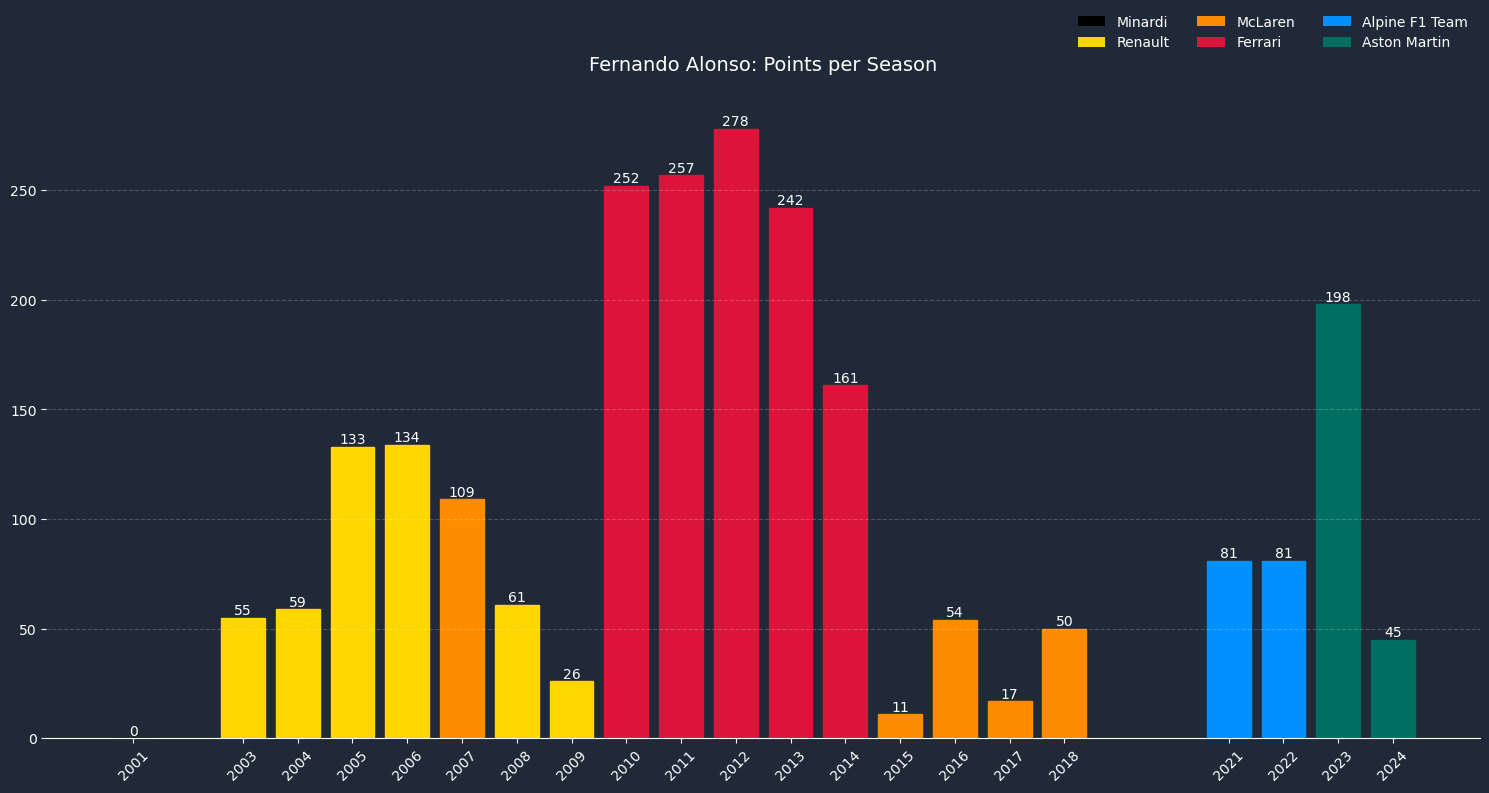

In [ ]:
def create_alonso_seasons_plot(drivers_df, results_df, races_df, constructors_df):
    alonso_id = drivers_df[
        (drivers_df['forename'] == 'Fernando') & 
        (drivers_df['surname'] == 'Alonso')
    ]['driverId'].iloc[0]
    
    alonso_results = results_df[results_df['driverId'] == alonso_id].merge(
        races_df[['raceId', 'year']], on='raceId'
    ).merge(
        constructors_df[['constructorId', 'name']], on='constructorId'
    )
    
    # Group by year and team
    season_data = alonso_results.groupby(['year', 'name'])['points'].sum().reset_index()
    
    season_teams = season_data.groupby('year')['name'].agg(list).reset_index()
    season_points = season_data.groupby('year')['points'].sum().reset_index()
    
    season_summary = season_points.merge(season_teams, on='year')
    
    team_colors = {
        'Minardi': '#000000',
        'Renault': '#FFD700',
        'McLaren': '#FF8C00',
        'Ferrari': '#DC143C',
        'Alpine F1 Team': '#0090FF',
        'Aston Martin': '#006F62'
    }
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(15, 8))
    
    bars = ax.bar(season_summary['year'], season_summary['points'])
    
    for bar, teams in zip(bars, season_summary['name']):
        if len(teams) == 1:
            bar.set_color(team_colors.get(teams[0], '#666666'))
        else:
            bar.set_color('#666666')  # Multiple teams in one season
    
    ax.set_facecolor('#1f2937')
    fig.patch.set_facecolor('#1f2937')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', color='white')
    
    plt.xticks(season_summary['year'], rotation=45)
    
    plt.title("Fernando Alonso: Points per Season", 
              pad=20, color='white', fontsize=14)
    
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=team)
                      for team, color in team_colors.items()]
    ax.legend(handles=legend_elements, loc='upper right', 
             bbox_to_anchor=(1, 1.15), ncol=3, frameon=False)
    
    ax.grid(axis='y', linestyle='--', alpha=0.2)
    
    plt.tight_layout()
    return fig

fig = create_alonso_seasons_plot(drivers, results, races, constructors)
plt.show()

In [32]:
def create_championship_winners_dataset(drivers_df, results_df, races_df, driver_standings_df):
    # Get the final race of each season
    final_races = races_df.groupby('year')['round'].max().reset_index()
    final_races = final_races.merge(races_df[['year', 'round', 'raceId']], on=['year', 'round'])
    
    # Get the championship standings after each final race
    champions = driver_standings_df.merge(final_races[['raceId', 'year']], on='raceId')
    
    display(champions)
    # Get the championship winners (position=1)
    champions = champions[champions['position'] == 1]
    
    champions = champions.merge(
        drivers_df[['driverId', 'forename', 'surname', 'nationality']], 
        on='driverId'
    )
    
    championship_winners = champions[[
        'year', 'driverId', 'forename', 'surname', 'nationality',
        'points', 'wins'
    ]].copy()
    
    championship_winners['driver_name'] = (
        championship_winners['forename'] + ' ' + championship_winners['surname']
    )
    championship_winners = championship_winners.sort_values('year')
    championship_winners = championship_winners.reset_index(drop=True)
    
    return championship_winners

championship_winners = create_championship_winners_dataset(drivers, results, races, driver_standings)

print("\nF1 Championship Winners Dataset:")
print("=" * 50)
print(championship_winners.head())

print("\nTotal number of championships:", len(championship_winners))
print("\nNumber of championships by driver:")
print(championship_winners['driver_name'].value_counts().head())
print("\nNumber of championships by nationality:")
print(championship_winners['nationality'].value_counts().head())

,driverStandingsId,raceId,driverId,points,position,positionText,wins,year
0,355,35,1,98.0,1,1,5,2008
1,356,35,2,60.0,6,6,0,2008
2,357,35,3,17.0,13,13,0,2008
3,358,35,4,61.0,5,5,2,2008
4,359,35,5,53.0,7,7,1,2008
...,...,...,...,...,...,...,...,...
3163,72513,1120,839,58.0,12,12,0,2023
3164,72514,1120,844,206.0,5,5,0,2023
3165,72515,1120,857,97.0,9,9,0,2023
3166,72516,1120,817,6.0,17,17,0,2023



F1 Championship Winners Dataset:
   year  driverId forename surname nationality  points  wins     driver_name
0  1950       642     Nino  Farina     Italian    30.0     3     Nino Farina
1  1951       579     Juan  Fangio   Argentine    31.0     3     Juan Fangio
2  1952       647  Alberto  Ascari     Italian    36.0     6  Alberto Ascari
3  1953       647  Alberto  Ascari     Italian    34.5     5  Alberto Ascari
4  1954       579     Juan  Fangio   Argentine    42.0     6     Juan Fangio

Total number of championships: 74

Number of championships by driver:
driver_name
Lewis Hamilton        7
Michael Schumacher    7
Juan Fangio           5
Alain Prost           4
Sebastian Vettel      4
Name: count, dtype: int64

Number of championships by nationality:
nationality
British       20
German        12
Brazilian      8
Argentine      5
Australian     4
Name: count, dtype: int64


In [33]:
def create_constructor_champions_dataset(constructors_df, constructor_standings_df, races_df):
    # Get the final race of each season
    final_races = races_df.groupby('year')['round'].max().reset_index()
    final_races = final_races.merge(races_df[['year', 'round', 'raceId']], 
                                  on=['year', 'round'])
    
    # Get the championship standings after each final race
    champions = constructor_standings_df.merge(
        final_races[['raceId', 'year']], 
        on='raceId'
    )
    
    # Get the championship winners (position=1)
    champions = champions[champions['position'] == 1]
    
    champions = champions.merge(
        constructors_df[['constructorId', 'name', 'nationality']], 
        on='constructorId'
    )
    
    constructor_champions = champions[[
        'year', 'constructorId', 'name', 'nationality',
        'points', 'wins'
    ]].copy()
    
    constructor_champions = constructor_champions.sort_values('year')
    
    constructor_champions = constructor_champions.reset_index(drop=True)
    
    return constructor_champions

constructor_champions = create_constructor_champions_dataset(constructors, constructor_standings, races)

print("\nF1 Constructor Championship Winners Dataset:")
print("=" * 50)
print(constructor_champions.head())

print("\nTotal number of championships:", len(constructor_champions))
print("\nNumber of championships by constructor:")
print(constructor_champions['name'].value_counts().head())
print("\nNumber of championships by nationality:")
print(constructor_champions['nationality'].value_counts().head())

# TODO: Think how to really check consecutive wins
consecutive_wins = constructor_champions['name'].value_counts().max()
print(f"\nLongest streak of consecutive championships: {consecutive_wins}")

most_recent = constructor_champions.iloc[-1]
print(f"\nMost recent constructor champion ({most_recent['year']}): {most_recent['name']}")


F1 Constructor Championship Winners Dataset:
   year  constructorId           name nationality  points  wins
0  1958            118        Vanwall     British    48.0     6
1  1959            170  Cooper-Climax     British    40.0     5
2  1960            170  Cooper-Climax     British    48.0     6
3  1961              6        Ferrari     Italian    45.0     5
4  1962             66            BRM     British    42.0     4

Total number of championships: 66

Number of championships by constructor:
name
Ferrari     16
Williams     9
Mercedes     8
McLaren      8
Red Bull     6
Name: count, dtype: int64

Number of championships by nationality:
nationality
British     32
Italian     17
German       8
Austrian     6
French       3
Name: count, dtype: int64

Longest streak of consecutive championships: 16

Most recent constructor champion (2023): Red Bull


In [ ]:
def find_best_position_gains(qualifying_df, results_df, drivers_df, races_df):
    position_changes = qualifying_df.merge(
        results_df[['raceId', 'driverId', 'positionOrder']], 
        on=['raceId', 'driverId']
    )
    
    position_changes = position_changes.merge(
        drivers_df[['driverId', 'forename', 'surname']], 
        on='driverId'
    )
    
    position_changes = position_changes.merge(
        races_df[['raceId', 'year', 'name']], 
        on='raceId'
    )
    
    # Convert qualifying position to numeric
    position_changes['position_q'] = pd.to_numeric(position_changes['position'])
    
    # Calculate position gain (qualifying position - finish position)
    position_changes['positions_gained'] = position_changes['position_q'] - position_changes['positionOrder']
    
    gains = position_changes[[
        'year', 'name', 'forename', 'surname', 
        'position_q', 'positionOrder', 'positions_gained'
    ]].copy()
    gains['driver_name'] = gains['forename'] + ' ' + gains['surname']
    
    # Filter for only positive gains (moving up the order)
    gains = gains[gains['positions_gained'] > 0]
    
    gains = gains.sort_values('positions_gained', ascending=False)
    top_10_gains = gains.head(10)
    
    result = top_10_gains[[
        'driver_name', 'year', 'name', 
        'position_q', 'positionOrder', 'positions_gained'
    ]].rename(columns={
        'name': 'race',
        'position_q': 'qualifying_position',
        'positionOrder': 'finishing_position'
    })
    
    return result

top_gains = find_best_position_gains(qualifying, results, drivers, races)

print("\nTop 10 Greatest Comebacks in F1 History (Qualifying to Race Finish)")
print("=" * 80)
display(top_gains.sort_values(by=['positions_gained', 'year'], ascending=False) .head(n=10))


Top 10 Greatest Comebacks in F1 History (Qualifying to Race Finish)


,driver_name,year,race,qualifying_position,finishing_position,positions_gained
7375,Kimi Räikkönen,2006,Bahrain Grand Prix,22,3,19
5963,Max Verstappen,2021,Russian Grand Prix,20,2,18
5138,Sebastian Vettel,2019,German Grand Prix,20,2,18
3925,Lewis Hamilton,2016,Belgian Grand Prix,21,3,18
3104,Lewis Hamilton,2014,Hungarian Grand Prix,21,3,18
1211,Fernando Alonso,2010,Monaco Grand Prix,24,6,18
480,Heikki Kovalainen,2007,Canadian Grand Prix,22,4,18
3970,Sebastian Vettel,2016,Singapore Grand Prix,22,5,17
9812,Mark Blundell,1995,Japanese Grand Prix,24,7,17
9945,Jean-Marc Gounon,1994,German Grand Prix,26,9,17


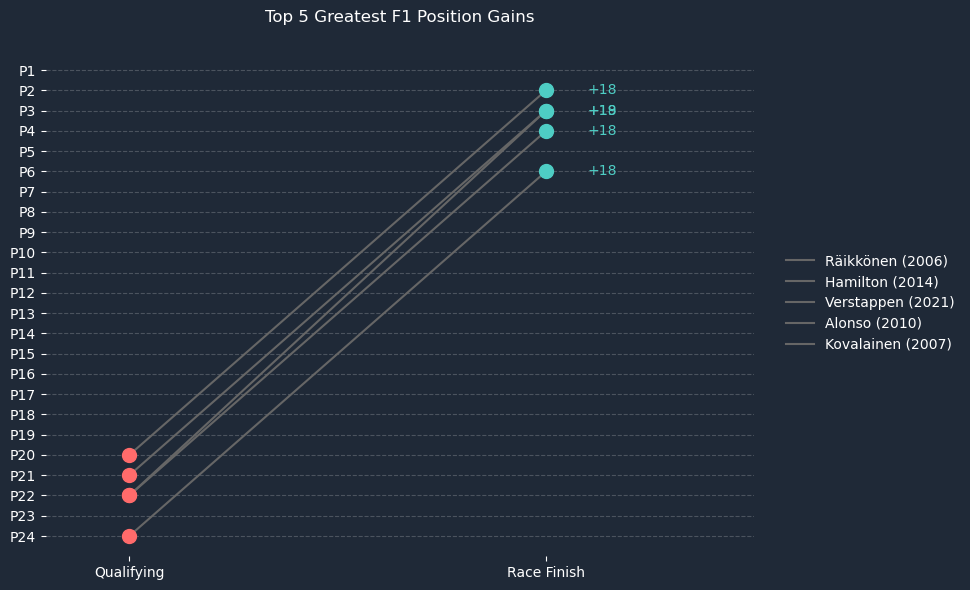

In [34]:
def plot_top_position_gains(qualifying_df, results_df, drivers_df, races_df):
    # Get only top 5 from our previous function
    top_gains = find_best_position_gains(qualifying_df, results_df, drivers_df, races_df).head(5)
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    start_color = '#ff6b6b'  # Red for qualifying
    end_color = '#4ecdc4'    # Green for finish
    line_color = '#666666'   # Grey for connecting lines
    
    x_positions = [0, 1]  # 0 for qualifying, 1 for race finish
    
    for idx, row in top_gains.iterrows():
        # Plot lines between qualifying and race positions
        plt.plot(x_positions, 
                [row['qualifying_position'], row['finishing_position']], 
                color=line_color, 
                label=f"{row['driver_name'].split(' ')[-1]} ({row['year']})")
        
        plt.scatter(0, row['qualifying_position'], color=start_color, s=100, zorder=5)
        plt.scatter(1, row['finishing_position'], color=end_color, s=100, zorder=5)
        
        plt.text(1.1, row['finishing_position'], 
                f"+{int(row['positions_gained'])}", 
                color=end_color, 
                va='center')

    ax.set_xlim(-0.2, 1.5)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['Qualifying', 'Race Finish'])
    
    # Set y-axis (reversed, as P1 should be at top)
    max_position = max(top_gains['qualifying_position'].max(), top_gains['finishing_position'].max())
    ax.set_ylim(max_position + 1, 0)
    ax.set_yticks(range(1, max_position + 1))
    ax.set_yticklabels([f'P{pos}' for pos in range(1, max_position + 1)])
    
    plt.title('Top 5 Greatest F1 Position Gains', pad=20, fontsize=12)
    plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), frameon=False)
    
    ax.set_facecolor('#1f2937')
    fig.patch.set_facecolor('#1f2937')
    ax.grid(True, axis='y', linestyle='--', alpha=0.2)
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    return fig

fig = plot_top_position_gains(qualifying, results, drivers, races)
plt.show()